In [ ]:
!pip install python-louvain
!pip install plotly

In [3]:
# System utilities
import os  # File and directory management
import requests  # Handling HTTP requests (downloading HCP dataset)
import tarfile  # Extracting compressed files (HCP dataset)

# Data handling and processing
import numpy as np  # Numerical computations and array manipulation
import pandas as pd  # DataFrame operations for organizing fMRI data
from sklearn.preprocessing import StandardScaler  # Normalization and scaling of data
from scipy.stats import zscore

#Graph setup functions
import community as community_louvain

# Machine learning & deep learning (PyTorch)
import torch  # Core PyTorch framework
import torch.nn as nn  # Neural Network layers
import torch.optim as optim  # Optimizers for training the model
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Graph neural network utilities
import networkx as nx  # Graph-based operations and visualization
from torch_geometric.nn import GCNConv, GATConv  # Graph Convolutional Network (GNN) layer
from torch_geometric.data import Data, DataLoader  # Handling graph-structured data
from torch_geometric.utils import dense_to_sparse


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import sklearn.metrics as metrics
from torch_geometric.nn import GCNConv, GATConv, GraphConv
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt  # Plotting and data visualization

#arbitrary glitch fixing
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="networkx")

#this toggles the test outputs for all the functions as they are instantiated
TestMode = True 
#some of the later functions in the pipeline also have a 'test_mode= true/false' argument
#this is for debugging/ eda on specific inputs  while TestMode is for generally testing/ demonstrating a function

**1. DOWNLOAD & LOAD HCP DATA**

In [31]:
# Define key parameters for data handling
N_SUBJECTS = 100  # Number of subjects to process
N_PARCELS = 360  # Number of brain parcels from Glasser parcellation
TR = 0.72  # Temporal resolution of fMRI data (in seconds per time point)
HEMIS = ["Right", "Left"]  # Hemispheres in the brain
RUNS = ["LR", "RL"]  # Left-to-right and right-to-left scan runs
N_RUNS = 2  # Number of runs per task

# Define the experiments and associated task conditions
EXPERIMENTS = {
    "MOTOR": {"cond": ["lf", "rf", "lh", "rh", "t", "cue"]},
    "WM": {"cond": ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools",
                        "2bk_body", "2bk_faces", "2bk_places", "2bk_tools"]},
    "SOCIAL": {"cond": ["ment", "rnd"]},
    "GAMBLING": {"cond": ["loss", "win"]},
    "EMOTION": {"cond": ["fear", "neut"]},
    "LANGUAGE": {"cond": ["math", "story"]},
    "RELATIONAL": {"cond": ["match", "relation"]}
}

TargetExperiments = ["WM", "EMOTION", "LANGUAGE"]  # Experiments of interest
TargetConditions = [
    "0bk_body", "0bk_faces", "0bk_places", "0bk_tools",
    "2bk_body", "2bk_faces", "2bk_places", "2bk_tools",
    "fear", "neut", "math", "story"
]

# Download parameters
fname = "hcp_task.tgz"  # Name of the compressed dataset file
url = "https://osf.io/2y3fw/download"  # URL to download the dataset from OSF
HCP_DIR = "./hcp_task"  # Directory where the extracted HCP data will be stored

# Check if dataset is already downloaded; if not, download it
if not os.path.isfile(fname):
    print("Downloading HCP dataset...")
    r = requests.get(url)  # Send a request to download the file
    if r.status_code == 200:  # Ensure successful request
        with open(fname, "wb") as fid:
            fid.write(r.content)  # Save the downloaded content to file
    else:
        raise Exception("Download failed!")  # Raise an error if download fails

# Extract dataset files if they haven't been extracted yet
if not os.path.exists(HCP_DIR):
    with tarfile.open(fname) as tfile:
        tfile.extractall('.')  # Extract all contents into the working directory

# Load subject IDs from the extracted dataset
SubjectIDs = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
SubjectIDs = list(SubjectIDs)

# Load region information for Glasser parcellation
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = {
    "name": regions[0].tolist(),
    "network": regions[1],
    "hemi": ["Right"] * (N_PARCELS // 2) + ["Left"] * (N_PARCELS // 2)
}

ventral_attention_parcels = [121, 134]
orbital_affective_parcels = [111, 165, 289, 291, 345]
dorsal_attention_parcels = [26, 139, 140, 206, 207, 320]
limbic_parcels = [109, 111, 165, 289, 291, 345]
auditory_parcels = [23, 102, 103, 123, 172, 173, 174, 282, 286, 287, 288, 303, 352, 353, 354]
default_mode_parcels = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Dictionary mapping subnetworks to their corresponding parcels
subnetworks = {
    "visual": [0, 1, 2, 3, 4, 5, 6, 12, 15, 16, 17, 18, 19, 20, 21, 22, 47, 48, 137, 141, 151, 152, 153, 155, 156, 157, 158, 159, 162, 186, 192, 195, 196, 197, 198, 199, 200, 201, 202, 227, 228, 317, 321, 331, 332, 333, 335, 336, 337, 338, 339, 342],
    "limbic": limbic_parcels,
    "auditory": auditory_parcels,
    "somatomotor": [7, 8, 35, 38, 39, 40, 41, 46, 50, 51, 52, 53, 54, 55, 99, 100, 101, 167, 187, 188, 215, 218, 219, 220, 221, 226, 230, 231, 232, 233, 234, 235, 279, 280, 281, 347],
    "frontoparietal": [13, 14, 28, 62, 72, 76, 79, 81, 82, 84, 96, 97, 110, 132, 143, 144, 148, 169, 170, 208, 242, 252, 256, 259, 260, 262, 264, 276, 277, 290, 298]
}


In [5]:
##Testing 1a. this returns the files put in the directory, which should be:
    #regions.npy
    #subjects
    #subjects_list.txt

import os

# Check if the HCP directory exists
if os.path.exists(HCP_DIR):
    print(f"HCP dataset successfully extracted at: {HCP_DIR}")
    print("Listing extracted files:")
    print(os.listdir(HCP_DIR))  # List files in the dataset directory
else:
    print("Error: HCP dataset directory not found!")

##Testing 1b. counts subjects from subject_list and returns entries
# Read the subject list properly
subject_list_path = os.path.join(HCP_DIR, 'subjects_list.txt')

if os.path.exists(subject_list_path):
    with open(subject_list_path, 'r') as f:
        subjects = f.read().split()  # Splitting by whitespace to extract subject IDs properly

    print(f"\nTotal subjects found: {len(subjects)}")
    print("First 5 subjects:", subjects[:5])  # Show first few subjects
else:
    print("Error: subjects_list.txt not found!")

HCP dataset successfully extracted at: ./hcp_task
Listing extracted files:
['regions.npy', 'subjects', 'subjects_list.txt']

Total subjects found: 100
First 5 subjects: ['100307', '100408', '101915', '102816', '103414']


fMRI time-series data exists for Subject 100307 (WM task, LR run)
Shape of fMRI time-series data: (360, 405)


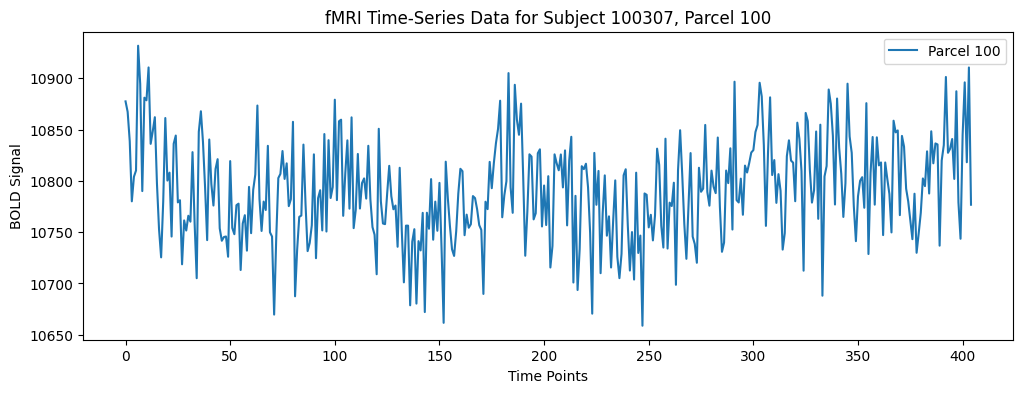

In [6]:
##Testing 1c. returns the time-series shape for a given subject and visualises the time-series
# Select a random subject and check their data
test_subject = subjects[0].strip()  # Remove newline characters
test_experiment = "WM"  # Working Memory task
test_run = "LR"  # Left-to-Right scan

# File path for the subject's fMRI data
fmri_file_path = f"{HCP_DIR}/subjects/{test_subject}/{test_experiment}/tfMRI_{test_experiment}_{test_run}/data.npy"

# Check if the time-series data file exists
if os.path.exists(fmri_file_path):
    print(f"fMRI time-series data exists for Subject {test_subject} ({test_experiment} task, {test_run} run)")
    fmri_data = np.load(fmri_file_path)
    print(f"Shape of fMRI time-series data: {fmri_data.shape}")  # Expected (360, timepoints)
else:
    print(f"Error: Time-series data not found for Subject {test_subject} ({test_experiment} task, {test_run} run)")

import matplotlib.pyplot as plt

# Plot time-series from a single parcel
parcel_idx = 100  # Choose a random parcel index
time_series = fmri_data[parcel_idx, :]  # Extract time-series for the selected parcel

plt.figure(figsize=(12, 4))
plt.plot(time_series, label=f"Parcel {parcel_idx}")
plt.xlabel("Time Points")
plt.ylabel("BOLD Signal")
plt.title(f"fMRI Time-Series Data for Subject {test_subject}, Parcel {parcel_idx}")
plt.legend()
plt.show()


In [32]:
#actual values need to be reviewed, but this is a dictionary for changing the glasser labels for visuals
Glasser_parcels_labels = ({
    0: "V1_L", 1: "V1_R", 2: "V2_L", 3: "V2_R", 4: "V3_L", 5: "V3_R",
    6: "V4_L", 7: "V4_R", 8: "V3A_L", 9: "V3A_R", 10: "V3B_L", 11: "V3B_R",
    12: "V6_L", 13: "V6_R", 14: "V6A_L", 15: "V6A_R", 16: "V7_L", 17: "V7_R",
    18: "V8_L", 19: "V8_R", 20: "IPS1_L", 21: "IPS1_R", 22: "MST_L", 23: "MST_R",
    24: "LO1_L", 25: "LO1_R", 26: "LO2_L", 27: "LO2_R", 28: "MT_L", 29: "MT_R",
    30: "V3CD_L", 31: "V3CD_R", 32: "PHC1_L", 33: "PHC1_R", 34: "PHC2_L", 35: "PHC2_R",
    36: "FFC_L", 37: "FFC_R", 38: "PIT_L", 39: "PIT_R", 40: "VVC_L", 41: "VVC_R",
    42: "IT_L", 43: "IT_R", 44: "TPOJ1_L", 45: "TPOJ1_R", 46: "TPOJ2_L", 47: "TPOJ2_R",
    48: "TPOJ3_L", 49: "TPOJ3_R", 50: "STSdp_L", 51: "STSdp_R", 52: "STSvp_L", 53: "STSvp_R",
    54: "STSva_L", 55: "STSva_R", 56: "FEF_L", 57: "FEF_R", 58: "PEF_L", 59: "PEF_R",
    60: "AIP_L", 61: "AIP_R", 62: "VIP_L", 63: "VIP_R", 64: "LIPd_L", 65: "LIPd_R",
    66: "LIPv_L", 67: "LIPv_R", 68: "MIP_L", 69: "MIP_R", 70: "V6_L", 71: "V6_R",
    72: "V6A_L", 73: "V6A_R", 74: "V7_L", 75: "V7_R", 76: "V8_L", 77: "V8_R",
    78: "PHT_L", 79: "PHT_R", 80: "PIT_L", 81: "PIT_R", 82: "TPOJ1_L", 83: "TPOJ1_R",
    84: "TPOJ2_L", 85: "TPOJ2_R", 86: "TPOJ3_L", 87: "TPOJ3_R", 88: "STSdp_L", 89: "STSdp_R",
    90: "STSvp_L", 91: "STSvp_R", 92: "STSva_L", 93: "STSva_R", 94: "TE1p_L", 95: "TE1p_R",
    96: "TE1a_L", 97: "TE1a_R", 98: "TE2p_L", 99: "TE2p_R", 100: "TE2a_L", 101: "TE2a_R",
    102: "TGd_L", 103: "TGd_R", 104: "Tg1_L", 105: "Tg1_R", 106: "Tg2_L", 107: "Tg2_R",
    108: "FST_L", 109: "FST_R", 110: "MTGd_L", 111: "MTGd_R", 112: "MTGv_L", 113: "MTGv_R",
    114: "PHT_L", 115: "PHT_R", 116: "PIT_L", 117: "PIT_R", 118: "TF_L", 119: "TF_R",
    120: "MST_L", 121: "MST_R", 122: "STV_L", 123: "STV_R", 124: "VVC_L", 125: "VVC_R",
    126: "PHC1_L", 127: "PHC1_R", 128: "PHC2_L", 129: "PHC2_R", 130: "RSC_L", 131: "RSC_R",
    132: "POS1_L", 133: "POS1_R", 134: "POS2_L", 135: "POS2_R", 136: "POS3_L", 137: "POS3_R",
    138: "DVT_L", 139: "DVT_R", 140: "VCC_L", 141: "VCC_R", 142: "PCC_L", 143: "PCC_R",
    144: "MCC_L", 145: "MCC_R", 146: "SCC_L", 147: "SCC_R", 148: "ACC_L", 149: "ACC_R",
    150: "OFC_L", 151: "OFC_R", 152: "p32_L", 153: "p32_R", 154: "a32pr_L", 155: "a32pr_R",
    156: "a32_L", 157: "a32_R", 158: "p24pr_L", 159: "p24pr_R", 160: "p24_L", 161: "p24_R",
    162: "a24pr_L", 163: "a24pr_R", 164: "a24_L", 165: "a24_R", 166: "s32_L", 167: "s32_R",
    168: "d32_L", 169: "d32_R", 170: "p10p_L", 171: "p10p_R", 172: "10v_L", 173: "10v_R",
    174: "10d_L", 175: "10d_R", 176: "9m_L", 177: "9m_R", 178: "9p_L", 179: "9p_R",
    180: "8m_L", 181: "8m_R", 182: "8d_L", 183: "8d_R", 184: "8v_L", 185: "8v_R",
    186: "p10r_L", 187: "p10r_R", 188: "a10p_L", 189: "a10p_R", 190: "a10r_L", 191: "a10r_R",
    192: "47m_L", 193: "47m_R", 194: "47s_L", 195: "47s_R", 196: "45_L", 197: "45_R",
    198: "44_L", 199: "44_R", 200: "p9-46v_L", 201: "p9-46v_R", 202: "a9-46v_L", 203: "a9-46v_R",
    204: "p9-46d_L", 205: "p9-46d_R", 206: "a9-46d_L", 207: "a9-46d_R", 208: "p8-46v_L", 209: "p8-46v_R",
    210: "a8-46v_L", 211: "a8-46v_R", 212: "8B_L", 213: "8B_R", 214: "s6-8_L", 215: "s6-8_R",
    216: "6v_L", 217: "6v_R", 218: "6d_L", 219: "6d_R", 220: "6a_L", 221: "6a_R",
    222: "6mp_L", 223: "6mp_R", 224: "6ma_L", 225: "6ma_R", 226: "SPL1_L", 
    227: "SPL1_R", 228: "7Pm_L", 229: "7Pm_R", 230: "7Am_L", 231: "7Am_R",
    232: "7PL_L", 233: "7PL_R", 234: "7AL_L", 235: "7AL_R", 236: "LIPv_L",
    237: "LIPv_R", 238: "VIP_L", 239: "VIP_R", 240: "AIP_L", 241: "AIP_R",
    242: "MIP_L", 243: "MIP_R", 244: "PEF_L", 245: "PEF_R", 246: "FEF_L",
    247: "FEF_R", 248: "IFJ_L", 249: "IFJ_R", 250: "A4_L", 251: "A4_R",
    252: "OP4_L", 253: "OP4_R", 254: "OP1_L", 255: "OP1_R", 256: "OP2-3_L",
    257: "OP2-3_R", 258: "RI_L", 259: "RI_R", 260: "POS1_L", 261: "POS1_R",
    262: "DVT_L", 263: "DVT_R", 264: "PGp_L", 265: "PGp_R", 266: "V3CD_L",
    267: "V3CD_R", 268: "31pd_L", 269: "31pd_R", 270: "31pv_L", 271: "31pv_R",
    272: "31a_L", 273: "31a_R", 274: "23d_L", 275: "23d_R", 276: "v23ab_L",
    277: "v23ab_R", 278: "d23ab_L", 279: "d23ab_R", 280: "8C_L", 281: "8C_R",
    282: "p32pr_L", 283: "p32pr_R", 284: "a32pr_L", 285: "a32pr_R", 286: "p32_L",
    287: "p32_R", 288: "s32_L", 289: "s32_R", 290: "8BM_L", 291: "8BM_R",
    292: "10d_L", 293: "10d_R", 294: "10v_L", 295: "10v_R", 296: "47m_L",
    297: "47m_R", 298: "a47r_L", 299: "a47r_R", 300: "11l_L", 301: "11l_R",
    302: "13l_L", 303: "13l_R", 304: "a24_L", 305: "a24_R", 306: "p24_L",
    307: "p24_R", 308: "33pr_L", 309: "33pr_R", 310: "a24pr_L", 311: "a24pr_R",
    312: "p24pr_L", 313: "p24pr_R", 314: "8Av_L", 315: "8Av_R", 316: "9m_L",
    317: "9m_R", 318: "9p_L", 319: "9p_R", 320: "10pp_L", 321: "10pp_R",
    322: "a9-46v_L", 323: "a9-46v_R", 324: "46_L", 325: "46_R", 326: "i6-8_L",
    327: "i6-8_R", 328: "s6-8_L", 329: "s6-8_R", 330: "a9-46d_L", 331: "a9-46d_R",
    332: "p9-46v_L", 333: "p9-46v_R", 334: "p9-46d_L", 335: "p9-46d_R",
    336: "8Ad_L", 337: "8Ad_R", 338: "8B_L", 339: "8B_R", 340: "p10p_L",
    341: "p10p_R", 342: "10r_L", 343: "10r_R", 344: "47s_L", 345: "47s_R",
    346: "a47_L", 347: "a47_R", 348: "11m_L", 349: "11m_R", 350: "13m_L",
    351: "13m_R", 352: "OFC_L", 353: "OFC_R", 354: "47l_L", 355: "47l_R",
    356: "LIM_L", 357: "LIM_R", 358: "13b_L", 359: "13b_R"
})

**2. LOAD & PROCESS DATA**


===== Testing: Load Single Time-Series =====
✅ Time-series data loaded for WM task, run LR
✅ Time-series data loaded for WM task, run RL
✅ Time-series data loaded for EMOTION task, run LR
✅ Time-series data loaded for EMOTION task, run RL


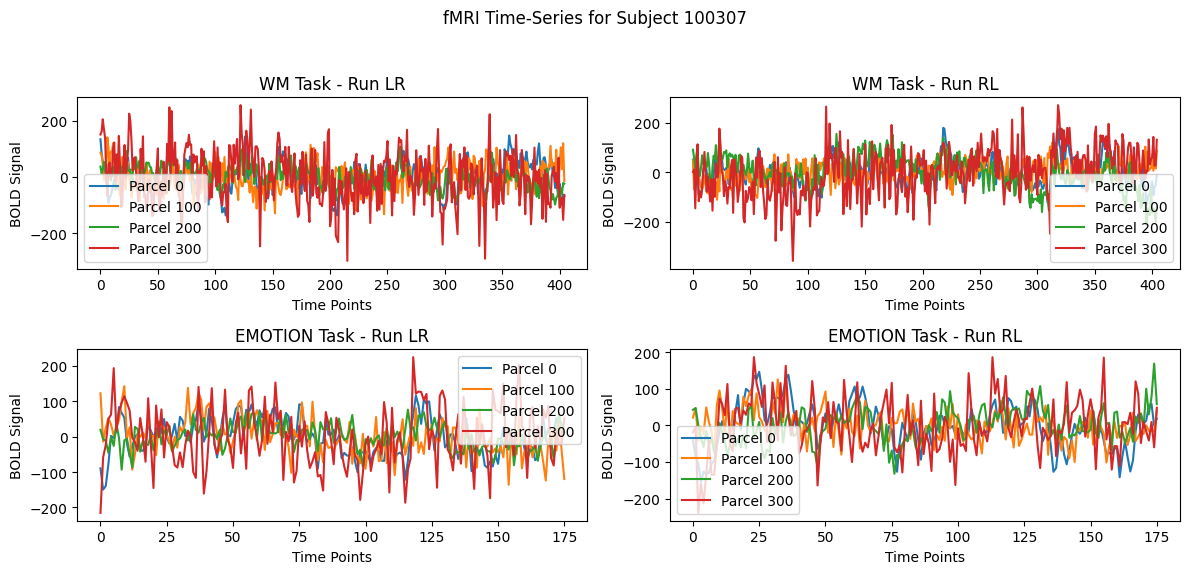

In [7]:
#Helper functions

# Function to load fMRI time-series data
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Arguments:
        subject (str):      Subject ID to load
        experiment (str):   Name of experiment (e.g., "WM")
        run (int):          Run index (0 or 1)
        remove_mean (bool): If True, subtracts the parcel-wise mean

    Returns:
        np.ndarray: Array of BOLD data values with shape (n_parcels x n_timepoints)
    """
    bold_run  = RUNS[run]  # Determine run type (LR or RL)
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    ts_path   = f"{bold_path}/data.npy"
    
    if not os.path.exists(ts_path):
        raise FileNotFoundError(f"Timeseries file not found: {ts_path}")
    ts = np.load(ts_path)
    
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)  # Normalize by removing mean signal
    return ts

#Testing
if TestMode:
    print("\n===== Testing: Load Single Time-Series =====")
    
    # Define test subject and tasks
    test_subject = SubjectIDs[0]  # Select the first subject
    test_experiments = ["WM", "EMOTION"]  # Working Memory and Emotion tasks
    test_runs = [0, 1]  # Test both runs (LR and RL)
    
    fig, axes = plt.subplots(len(test_experiments), len(test_runs), figsize=(12, 6))
    fig.suptitle(f"fMRI Time-Series for Subject {test_subject}")
    
    for i, experiment in enumerate(test_experiments):
        for j, run in enumerate(test_runs):
            try:
                fmri_data = load_single_timeseries(test_subject, experiment, run)
                assert isinstance(fmri_data, np.ndarray), "Error: Time-series data is not a NumPy array."
                assert fmri_data.shape[0] == N_PARCELS, f"Error: Expected {N_PARCELS} parcels, got {fmri_data.shape[0]}"
                
                # Select a few parcels for visualization
                selected_parcels = [0, 100, 200, 300]  # Four representative parcels
                time_series = fmri_data[selected_parcels, :]
                
                ax = axes[i, j] if len(test_experiments) > 1 else axes[j]
                for idx, parcel in enumerate(selected_parcels):
                    ax.plot(time_series[idx, :], label=f"Parcel {parcel}")
                ax.set_title(f"{experiment} Task - Run {RUNS[run]}")
                ax.set_xlabel("Time Points")
                ax.set_ylabel("BOLD Signal")
                ax.legend()
                print(f"✅ Time-series data loaded for {experiment} task, run {RUNS[run]}")
            except FileNotFoundError as e:
                print(f"❌ Time-series file missing for {experiment} task, run {RUNS[run]}: {e}")
            except AssertionError as e:
                print(f"❌ Time-series test failed for {experiment} task, run {RUNS[run]}: {e}")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [8]:
# Function to load event variables (EVs) associated with task conditions
def load_evs_as_dict(subject, experiment, run):
    """Load Explanatory Variables (EVs) data for one task experiment.

    Arguments:
        subject (str): Subject ID
        experiment (str): Experiment name
        run (int): Run index (0 or 1)
    
    Returns:
        dict: Dictionary containing EV data for each task condition
    """
    
    # Ensure `run` is an index, not a string like 'LR'
    if isinstance(run, str):
        if run in RUNS:
            run = RUNS.index(run)  # Convert 'LR' or 'RL' to 0 or 1
            print(f"✅ Converted: RUNS[{run}] = {RUNS[run]} for experiment {experiment}")
        else:
            raise ValueError(f"❌ Invalid run string: {run}. Expected 'LR' or 'RL'.")

    print(f"🔍 Checking: RUNS[{run}] = {RUNS[run]} for experiment {experiment}")

    task_key = f"tfMRI_{experiment}_{RUNS[run]}"

    # Ensure experiment exists
    if experiment not in EXPERIMENTS:
        raise ValueError(f"❌ Experiment {experiment} not found in EXPERIMENTS.")

    evs = {}
    for cond in EXPERIMENTS[experiment]["cond"]:
        ev_file = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        if not os.path.exists(ev_file):
            raise FileNotFoundError(f"❌ EV file not found: {ev_file}")
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        evs[cond] = dict(zip(["onset", "duration", "amplitude"], ev_array))

    return evs


# ----------------------------
# Test: Load EVs Data
# ----------------------------
if TestMode:
    print("\n===== Testing: Load EVs Data =====")
    try:
        ev_data = load_evs_as_dict(test_subject, test_experiment, test_run)
        assert isinstance(ev_data, dict), "Error: EV data should be a dictionary."
        assert len(ev_data) > 0, "Error: No conditions found in EV data."
        print("✅ EV data successfully loaded with conditions:", list(ev_data.keys()))
    except FileNotFoundError as e:
        print(f"❌ EV file missing: {e}")
    except AssertionError as e:
        print(f"❌ EVs test failed: {e}")
    except ValueError as e:
        print(f"❌ Value Error: {e}")



===== Testing: Load EVs Data =====
✅ Converted: RUNS[0] = LR for experiment WM
🔍 Checking: RUNS[0] = LR for experiment WM
✅ EV data successfully loaded with conditions: ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools', '2bk_body', '2bk_faces', '2bk_places', '2bk_tools']



===== Testing: Create DataFrame =====
🔍 Checking: RUNS[0] = LR for experiment WM
🔍 Checking: RUNS[1] = RL for experiment WM
✅ Dataframe successfully created with shape: (608, 368)


,subject,experiment,run,condition,timepoint,EV_onset,EV_duration,EV_amplitude,parcel_1,parcel_2,...,parcel_351,parcel_352,parcel_353,parcel_354,parcel_355,parcel_356,parcel_357,parcel_358,parcel_359,parcel_360
0,100307,WM,LR,0bk_body,53,38.664,27.5,1.0,-44.694886,-19.162548,...,-24.156343,-22.985671,34.883846,-7.468287,35.659132,-3.624241,-35.957685,51.982878,29.156648,35.071995
1,100307,WM,LR,0bk_body,54,38.664,27.5,1.0,-67.904335,-33.453936,...,-73.996588,-86.512508,0.381860,33.778038,33.063357,-48.983215,56.499064,113.572917,-63.278418,147.497490
2,100307,WM,LR,0bk_body,55,38.664,27.5,1.0,-37.515938,31.931524,...,-34.480509,-48.411689,12.531628,-65.670744,22.379514,51.352836,12.852111,-67.745450,6.162614,-7.964878
3,100307,WM,LR,0bk_body,56,38.664,27.5,1.0,-35.847759,-22.773863,...,-12.457821,19.066965,-7.612238,59.412752,21.759421,39.232106,26.070502,-32.213794,14.175263,42.580229
4,100307,WM,LR,0bk_body,57,38.664,27.5,1.0,20.960684,53.526726,...,-31.012622,-56.020204,-45.781065,97.380577,23.851881,22.205080,26.250587,-19.791108,46.222322,75.048827


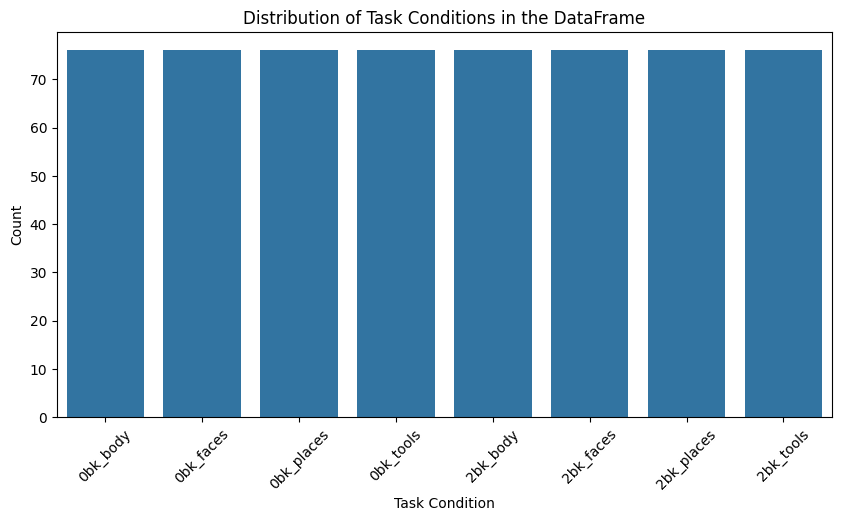

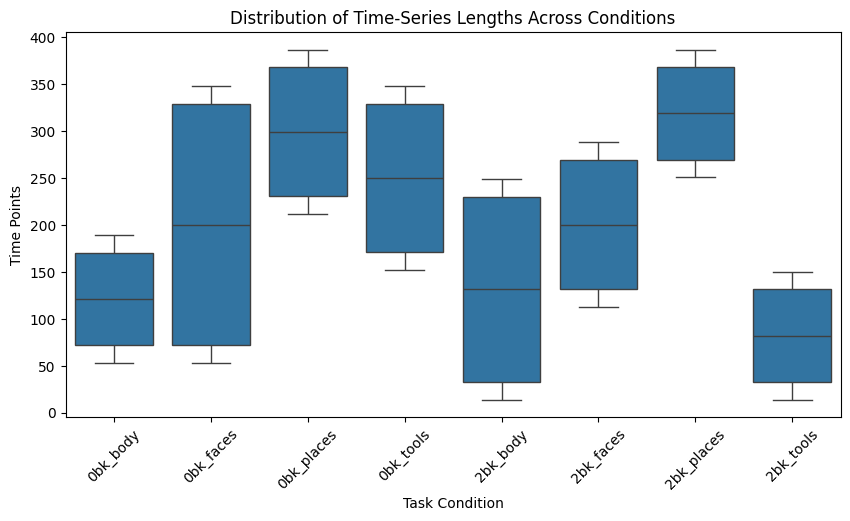

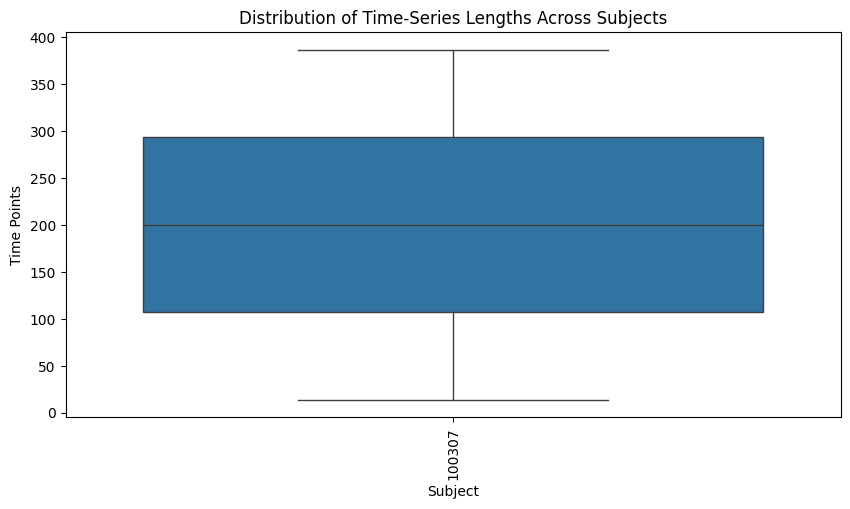

In [9]:
# Function to create a dataframe of fMRI data combined with task conditions
def create_dataframe(subject, experiment):
    """Creates a dataframe containing parcel-based BOLD signals from a subject for each condition.
    
    Arguments:
        subject (str): Subject ID
        experiment (str): Experiment name
    
    Returns:
        pd.DataFrame: Dataframe containing BOLD time-series and corresponding conditions
    """
    all_data = []
    
    for run in range(2):  # Iterate over LR and RL runs
        try:
            ts = load_single_timeseries(subject, experiment, run)
            evs = load_evs_as_dict(subject, experiment, run)
        except FileNotFoundError as e:
            print(e)
            continue

        n_parcels, n_timepoints = ts.shape
        
        for condition, ev_data in evs.items():
            onset_times = ev_data["onset"]
            durations = ev_data["duration"]
            amplitudes = ev_data["amplitude"]
            
            for onset, duration, amplitude in zip(onset_times, durations, amplitudes):
                start_frame = int(onset / TR)
                end_frame = start_frame + int(duration / TR)
                
                for time_point in range(start_frame, end_frame):
                    if time_point < n_timepoints:  # Ensure time point is within bounds
                        row = {
                            "subject": subject,
                            "experiment": experiment,
                            "run": RUNS[run],
                            "condition": condition,
                            "timepoint": time_point,
                            "EV_onset": onset,
                            "EV_duration": duration,
                            "EV_amplitude": amplitude
                        }
                        # Add BOLD signal data for all parcels
                        row.update({f"parcel_{i + 1}": ts[i, time_point] for i in range(n_parcels)})
                        all_data.append(row)
    
    df = pd.DataFrame(all_data)
    return df

# Testing
if TestMode:
    print("\n===== Testing: Create DataFrame =====")
    try:
        df = create_dataframe(test_subject, test_experiment)
        assert isinstance(df, pd.DataFrame), "Error: Output is not a DataFrame."
        assert "condition" in df.columns, "Error: Missing 'condition' column in DataFrame."
        assert "timepoint" in df.columns, "Error: Missing 'timepoint' column in DataFrame."
        print("✅ Dataframe successfully created with shape:", df.shape)

        # Display dataframe sample
        from IPython.display import display
        display(df.head())  # Shows the first few rows
        
        # Visualize the distribution of conditions in the dataset
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x="condition", order=df["condition"].value_counts().index)
        plt.xticks(rotation=45)
        plt.xlabel("Task Condition")
        plt.ylabel("Count")
        plt.title("Distribution of Task Conditions in the DataFrame")
        plt.show()
        
        # Visualize the distribution of time-series lengths across conditions
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df, x="condition", y="timepoint", order=df["condition"].value_counts().index)
        plt.xticks(rotation=45)
        plt.xlabel("Task Condition")
        plt.ylabel("Time Points")
        plt.title("Distribution of Time-Series Lengths Across Conditions")
        plt.show()
        
        # Visualize the distribution of time-series lengths across subjects
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df, x="subject", y="timepoint")
        plt.xticks(rotation=90)
        plt.xlabel("Subject")
        plt.ylabel("Time Points")
        plt.title("Distribution of Time-Series Lengths Across Subjects")
        plt.show()
        
    except FileNotFoundError as e:
        print(f"❌ Data creation failed due to missing file: {e}")
    except AssertionError as e:
        print(f"❌ Dataframe test failed: {e}")
    

In [10]:
# Function to save data to CSV
def save_to_csv(df, output_folder, filename):
    """Saves a dataframe as a CSV file in the specified directory.
    
    Arguments:
        df (pd.DataFrame): Dataframe to save
        output_folder (str): Directory where file should be saved
        filename (str): Name of the output CSV file
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    file_path = os.path.join(output_folder, filename)
    df.to_csv(file_path, index=False)

#Testing
test_output_folder = "./test_output"
os.makedirs(test_output_folder, exist_ok=True)
test_filename = "test_subject_data.csv"

try:
    save_to_csv(df, test_output_folder, test_filename)
    loaded_df = pd.read_csv(os.path.join(test_output_folder, test_filename))
    assert isinstance(loaded_df, pd.DataFrame), "Error: Loaded file is not a DataFrame."
    assert not loaded_df.empty, "Error: Loaded DataFrame is empty."
    print("✅ CSV save and load test passed successfully.")
except Exception as e:
    print(f"❌ CSV save/load test failed: {e}")

✅ CSV save and load test passed successfully.


In [11]:
# Function to process a subject's data and save it (WIP)
def process_subject(subject, experiments, output_folder):
    """Processes fMRI data for a subject, creates dataframes, and saves them as CSVs.
    
    Arguments:
        subject (str): Subject ID
        experiments (list): List of experiments to process
        output_folder (str): Directory where output CSVs should be saved
    """
    all_dfs = []
    
    for experiment in experiments:
        df = create_dataframe(subject, experiment)
        if not df.empty:
            all_dfs.append(df)
        else:
            print(f"No data to save for subject {subject}, experiment {experiment}.")
    
    if all_dfs:
        final_df = pd.concat(all_dfs, axis=0)
        save_to_csv(final_df, output_folder, f"{subject}_data.csv")
    else:
        print(f"No data to save for subject {subject}.")
    
    return

**Matrix Preparation**

In [12]:
#Raw 3D Matrix construction function
def matrix_setup(experiment, test_mode=True):
    """
    Processes fMRI data for a given experiment and returns a structured 3D matrix.

    Arguments:
        experiment (str): The HCP experiment to process (e.g., "WM", "EMOTION").
        test_mode (bool): If True, generates detailed debugging output and visualizations.

    Returns:
        np.ndarray: 3D matrix (n_exposures, n_parcels, time_steps)
        np.ndarray: Label vector (condition labels for each exposure)
        pd.DataFrame: The processed fMRI DataFrame for reference
    """
    print(f"\n===== Running fMRI Data Processing for {experiment} =====")

    # Step 1: Load DataFrame
    fmri_df = create_dataframe(test_subject, experiment)
    print(f"✅ fMRI DataFrame loaded with shape: {fmri_df.shape}")

    # Step 2: Drop unnecessary columns
    fmri_df = fmri_df.drop(columns=['run', 'experiment', 'EV_amplitude'])
    print("✅ Dropped irrelevant columns: run, experiment, EV_amplitude")

    # Step 3: Encode condition labels numerically
    condition_mapping = {cond: i for i, cond in enumerate(EXPERIMENTS[experiment]["cond"])}
    fmri_df["condition"] = fmri_df["condition"].map(condition_mapping)
    print("✅ Encoded condition labels numerically")

    # Step 4: Align time-series exposures
    fmri_df['adjusted_time'] = fmri_df['timepoint'] - fmri_df['EV_onset']
    fmri_df = fmri_df.drop(columns=['EV_onset', 'EV_duration'])
    print("✅ Aligned time-series exposures and dropped onset/duration columns")

    # Step 5: Extract relevant columns
    parcel_columns = [col for col in fmri_df.columns if col.startswith("parcel_")]
    
    # Debugging: Ensure exactly 360 parcels
    if len(parcel_columns) != 360:
        raise ValueError(f"❌ Parcel column count mismatch: Expected 360, Found {len(parcel_columns)}")

    fmri_df_parcel = fmri_df[['subject', 'condition', 'adjusted_time'] + parcel_columns]

    # Step 6: Reshape into 3D matrix
    unique_exposures = fmri_df_parcel[['subject', 'condition', 'adjusted_time']].drop_duplicates()
    n_exposures = len(unique_exposures)
    n_parcels = 360
    time_steps = int(fmri_df_parcel['adjusted_time'].max()) + 1  # Time steps from max adjusted time

    print(f"📊 Data dimensions: n_exposures={n_exposures}, n_parcels={n_parcels}, time_steps={time_steps}")

    fmri_3d_matrix = np.zeros((n_exposures, n_parcels, time_steps))
    labels = np.zeros(n_exposures)

    for i, (_, exposure) in enumerate(unique_exposures.iterrows()):
        exposure_data = fmri_df_parcel[
            (fmri_df_parcel['subject'] == exposure['subject']) & 
            (fmri_df_parcel['condition'] == exposure['condition']) &
            (fmri_df_parcel['adjusted_time'] == exposure['adjusted_time'])
        ]
        parcel_values = exposure_data[parcel_columns].values.T  # Select only parcel data
        fmri_3d_matrix[i, :, :parcel_values.shape[1]] = parcel_values  # Assign data
        labels[i] = exposure['condition']  # Assign label

    print(f"✅ 3D fMRI matrix constructed with shape: {fmri_3d_matrix.shape}")

    # ----------------------------
    # Test Mode Output
    # ----------------------------
    if test_mode:
        print("\n===== TEST MODE OUTPUT =====")
        
        # Sample DataFrame Preview
        print("\n🔍 Sample of Transformed DataFrame:")
        display(fmri_df.head())

        # Encoded Label Distribution
        print("\n🔍 Encoded Condition Labels Distribution:")
        print(pd.Series(labels).value_counts())

        # Visualize Adjusted Time-Series Length Distribution
        plt.figure(figsize=(10, 5))
        sns.histplot(fmri_df['adjusted_time'], bins=20, kde=True)
        plt.xlabel("Adjusted Time-Series Length")
        plt.ylabel("Frequency")
        plt.title(f"Distribution of Adjusted Time-Series Lengths for {experiment}")
        plt.show()

    return fmri_3d_matrix, labels, fmri_df  # ✅ Now returning fmri_df!


In [13]:
#WM specific label adjustment
def adjust_wm_labels(labels):
    """
    Adjusts WM labels from categorical (0-7) encoding to binary 0-back (0) and 2-back (1).

    Arguments:
        labels (np.ndarray): Array of categorical labels (0-7).

    Returns:
        np.ndarray: Adjusted binary labels (0 = 0-back, 1 = 2-back).
    """
    print("\n===== Adjusting WM Labels =====")
    
    # Define mapping: 0bk → 0, 2bk → 1
    wm_label_mapping = {
        0: 0,  # 0bk_body
        1: 0,  # 0bk_faces
        2: 0,  # 0bk_places
        3: 0,  # 0bk_tools
        4: 1,  # 2bk_body
        5: 1,  # 2bk_faces
        6: 1,  # 2bk_places
        7: 1   # 2bk_tools
    }
    
    # Apply mapping
    adjusted_labels = np.vectorize(wm_label_mapping.get)(labels)
    
    print(f"✅ Adjusted Labels: {np.unique(adjusted_labels, return_counts=True)}")
    
    return adjusted_labels


In [14]:
#this further cleans the raw 3D matrix specifically for model input and includes standardisation (we may remove)
def construct_parcellation_matrix(fmri_3d_matrix, fmri_df, standardize=True, test_mode=True):
    """
    Constructs the main parcellation matrix from the fMRI 3D matrix.
    
    Arguments:
        fmri_3d_matrix (np.ndarray): 3D fMRI matrix (n_exposures, 360, time_steps)
        fmri_df (pd.DataFrame): Original fMRI DataFrame for reference (used to retain subject and condition if needed).
        standardize (bool): Whether to apply Z-score normalization across the time dimension.
        test_mode (bool): If True, prints debug information and visualizations.
    
    Returns:
        np.ndarray: Parcellation matrix (n_exposures, 360, time_steps)
        pd.DataFrame: Metadata table containing subject and condition labels.
    """
    print("\n===== Constructing Parcellation Matrix =====")
    
    # Extract subject and condition labels
    metadata_df = fmri_df[['subject', 'condition']].drop_duplicates().reset_index(drop=True)
    
    # Verify dimensions
    n_exposures, n_parcels, time_steps = fmri_3d_matrix.shape
    print(f"✅ Data dimensions: n_exposures={n_exposures}, n_parcels={n_parcels}, time_steps={time_steps}")
    
    # Step 1: Standardize Data (if requested)
    if standardize:
        fmri_3d_matrix = zscore(fmri_3d_matrix, axis=2)  # Standardize across the time axis
        print("✅ Applied Z-score normalization to parcels across time.")
    
    # Step 2: Verify structure
    assert fmri_3d_matrix.shape == (n_exposures, n_parcels, time_steps), "Error: Shape mismatch in parcellation matrix."
    print("✅ Parcellation matrix constructed successfully!")
    
    # Step 3: Test Mode Visualizations
    if test_mode:
        print("Sample Metadata Table:")
        print(metadata_df.head())
        
        print("Sample Parcellation Data (First Exposure, First 5 Parcels):")
        print(fmri_3d_matrix[0, :5, :10])  # Show first 10 time points for first 5 parcels
    
    return fmri_3d_matrix, metadata_df

# ============================
# TEST: Construct Parcellation Matrix
# ============================
if TestMode:
    print("\n===== Running Parcellation Matrix Construction =====")
    try:
        parcellation_matrix, metadata = construct_parcellation_matrix(fmri_3d_matrix, fmri_df, standardize=True, test_mode=True)
        print("✅ Parcellation matrix construction completed with shape:", parcellation_matrix.shape)
    except Exception as e:
        print(f"❌ Error in parcellation matrix construction: {e}")


===== Running Parcellation Matrix Construction =====
❌ Error in parcellation matrix construction: name 'fmri_3d_matrix' is not defined


In [15]:
#establish function for constructing target matrix
def construct_target_matrix(fmri_3d_matrix, labels, percentile_threshold=85, test_mode=False):
    """
    Constructs a target matrix by averaging parcel activations over time and thresholding high-activation parcels.
    
    Arguments:
        fmri_3d_matrix (np.ndarray): 3D matrix of shape (n_exposures, 360, time_steps).
        labels (np.ndarray): 1D array of condition labels (0 for 0-back, 1 for 2-back).
        percentile_threshold (float): Activation percentile threshold to classify significant activations.
        test_mode (bool): If True, provides debugging visualizations.
    
    Returns:
        np.ndarray: Target matrix of shape (n_exposures, 360).
    """
    print("\n===== Constructing Target Matrix =====")

    n_exposures, n_parcels, time_steps = fmri_3d_matrix.shape

    # Step 1: Compute time-averaged activations (mean across time axis)
    time_averaged_activations = np.mean(fmri_3d_matrix, axis=2)

    # Step 2: Compute the activation threshold per parcel
    activation_thresholds = np.percentile(time_averaged_activations, percentile_threshold, axis=0)

    # Step 3: Apply thresholding to identify significant activations
    target_matrix = np.where(time_averaged_activations >= activation_thresholds, 1, 0)

    # Step 4: Zero-out 0-back trials
    zero_back_indices = np.where(labels == 0)[0]
    target_matrix[zero_back_indices, :] = 0

    print(f"✅ Target matrix constructed with shape: {target_matrix.shape}")

    # Step 5: Debugging Visualizations
    if test_mode:
        debug_target_matrix(target_matrix)

    return target_matrix

def debug_target_matrix(target_matrix):
    """
    Debugging and visualization for the target matrix.
    
    Arguments:
        target_matrix (np.ndarray): The binary target matrix.
    """
    print("\n===== Target Matrix Debugging =====")

    # Calculate and print sparsity
    total_ones = np.sum(target_matrix)
    total_zeros = target_matrix.size - total_ones
    sparsity = total_zeros / target_matrix.size
    print(f"⚠️ Target Matrix Sparsity: {sparsity:.4f} (Proportion of 0s)")
    print(f"📊 Total 1s in Matrix: {total_ones}, Total 0s: {total_zeros}")

    # Plot histogram of activations per parcel
    plt.figure(figsize=(10, 5))
    parcel_activations = np.sum(target_matrix, axis=0)  # Sum over exposures
    plt.bar(range(360), parcel_activations, color="royalblue", alpha=0.7)
    plt.xlabel("Parcel Index (Brain Regions)")
    plt.ylabel("Number of Exposures Marked as 1")
    plt.title("Activation Frequency Per Parcel (Histogram)")
    plt.show()

    # Heatmap of the target matrix
    plt.figure(figsize=(12, 6))
    sns.heatmap(target_matrix[:1000, :], cmap="Blues", cbar=True)
    plt.xlabel("Parcels (Brain Regions)")
    plt.ylabel("Exposures (Stimulus Trials)")
    plt.title("Target Matrix Heatmap")
    plt.show()



In [71]:
#Adjacency matrix construction function
def construct_adjacency_matrix(parcellation_matrix, threshold=0.3, binarize=True, region_labels=None, test_mode=False):
    """
    Constructs an adjacency matrix using functional connectivity and visualizes graph properties.

    Arguments:
        parcellation_matrix (np.ndarray): fMRI parcellation data (n_exposures, 360, time_steps).
        threshold (float): Correlation value to consider an edge (default=0.3).
        binarize (bool): If True, creates a binary adjacency matrix; otherwise, retains correlation weights.
        region_labels (dict, optional): A dictionary mapping parcel indices to region names.
        test_mode (bool): If True, generates debug outputs and visualizations.

    Returns:
        np.ndarray: Adjacency matrix of shape (360, 360).
        dict: Louvain community structure.
    """
    print("\n===== Constructing Adjacency Matrix =====")

    # Step 1: Compute Pearson Correlation Matrix across parcels
    n_exposures, n_parcels, time_steps = parcellation_matrix.shape

    # Reshape: each parcel as a row, concatenated over exposures and time-points
    reshaped_data = parcellation_matrix.transpose(1, 0, 2).reshape(360, -1)  # Shape: (360, n_exposures*time_steps)

    # Compute correlation matrix
    corr_matrix = np.corrcoef(reshaped_data)

    # Ensure correct shape
    adj_matrix = corr_matrix  # Shape should be (360, 360)

    # Step 2: Apply Thresholding
    if binarize:
        adj_matrix = np.where(np.abs(adj_matrix) > threshold, 1, 0)

    # Step 3: Remove Self-Connections
    np.fill_diagonal(adj_matrix, 0)

    print(f"✅ Adjacency matrix constructed with shape: {adj_matrix.shape}")

    # Step 4: Visualizations
    if test_mode:
        print("\n===== TEST MODE OUTPUT =====")

        # Heatmap of adjacency matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(adj_matrix, cmap="Blues", square=True)
        plt.title("Adjacency Matrix (Functional Connectivity)")
        plt.xlabel("Parcel Index")
        plt.ylabel("Parcel Index")
        plt.show()

        # Convert adjacency matrix to Graph
        G = nx.from_numpy_array(adj_matrix)

        # Remove isolated nodes (no connections)
        G.remove_nodes_from(list(nx.isolates(G)))

        # Calculate Degree Centrality
        degree_centrality = nx.degree_centrality(G)
        centrality_values = list(degree_centrality.values())  # Convert to list
        cmap = plt.cm.plasma  # Choose color map
        node_colors = [cmap(value) for value in centrality_values]  # Normalize colors

        # Assign node labels (either Glasser indices or custom region names)
        default_labels = {i: f'Parcel {i}' for i in range(360)}
        labels = region_labels if region_labels else default_labels
        graph_labels = {i: labels[i] for i in G.nodes()}  # Apply custom labels

        # Generate force-directed layout for better visualization
        pos = nx.spring_layout(G, seed=42, k=0.35)  # Adjust 'k' for spread (increase to spread more)

        # Plot Graph with Degree Centrality Coloring
        plt.figure(figsize=(18, 18))  # Bigger figure for better readability
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, cmap=cmap)
        nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.5)

        # Adjust label positions slightly upwards to avoid overlap
        label_pos = {k: (v[0], v[1] + 0.03) for k, v in pos.items()}  # Shift labels up slightly
        nx.draw_networkx_labels(G, label_pos, graph_labels, font_size=7, font_color="black", alpha=0.9)

        plt.title("Brain Connectivity Graph (Force-Directed Layout & Centrality Coloring)", fontsize=12)
        plt.show()

        # Step 5: Community Detection
        print("\n===== Community Detection =====")

        # Louvain Community Detection
        partition = community_louvain.best_partition(G)
        unique_communities = len(set(partition.values()))
        print(f"🔹 Louvain detected {unique_communities} communities.")

        # Step 6: Print Top 10 Most Connected Nodes
        print("\n===== Top 10 Most Connected Brain Regions =====")
        top_10_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        for idx, (node, centrality) in enumerate(top_10_nodes):
            print(f"{idx+1}. Parcel {node} ({labels[node]}) - Degree Centrality: {centrality:.3f}")

        return adj_matrix, partition

    return adj_matrix


In [17]:
#behaviour matrix function maybe though we could drop that due to time pressure for now


===== Running fMRI Data Processing for WM =====
🔍 Checking: RUNS[0] = LR for experiment WM
🔍 Checking: RUNS[1] = RL for experiment WM
✅ fMRI DataFrame loaded with shape: (608, 368)
✅ Dropped irrelevant columns: run, experiment, EV_amplitude
✅ Encoded condition labels numerically
✅ Aligned time-series exposures and dropped onset/duration columns
📊 Data dimensions: n_exposures=608, n_parcels=360, time_steps=135
✅ 3D fMRI matrix constructed with shape: (608, 360, 135)

===== Adjusting WM Labels =====
✅ Adjusted Labels: (array([0, 1]), array([304, 304], dtype=int64))

===== Constructing Parcellation Matrix =====
✅ Data dimensions: n_exposures=608, n_parcels=360, time_steps=135
✅ Applied Z-score normalization to parcels across time.
✅ Parcellation matrix constructed successfully!

===== Constructing Target Matrix =====
✅ Target matrix constructed with shape: (608, 360)

===== Constructing Adjacency Matrix =====
✅ Adjacency matrix constructed with shape: (360, 360)

===== TEST MODE OUTPUT =

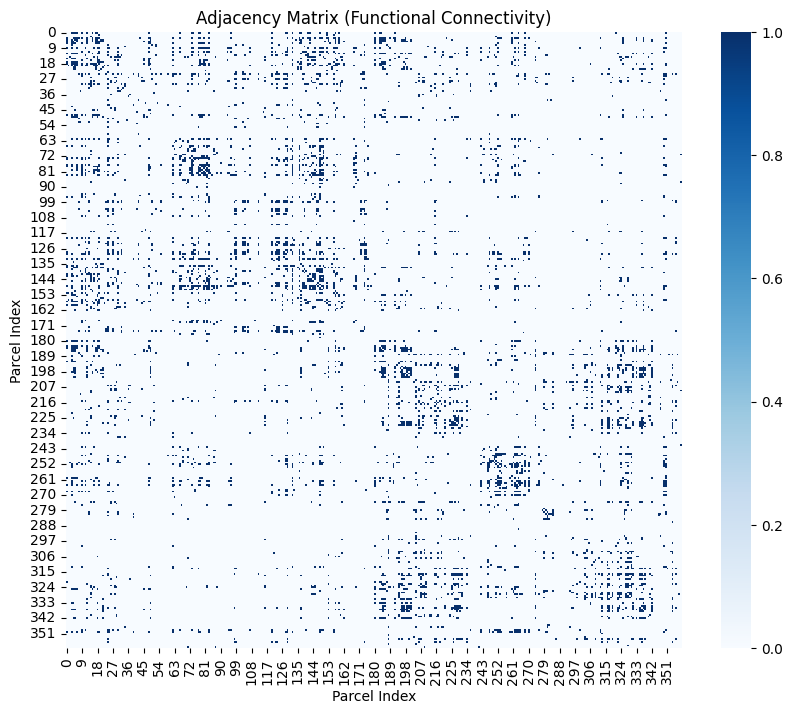

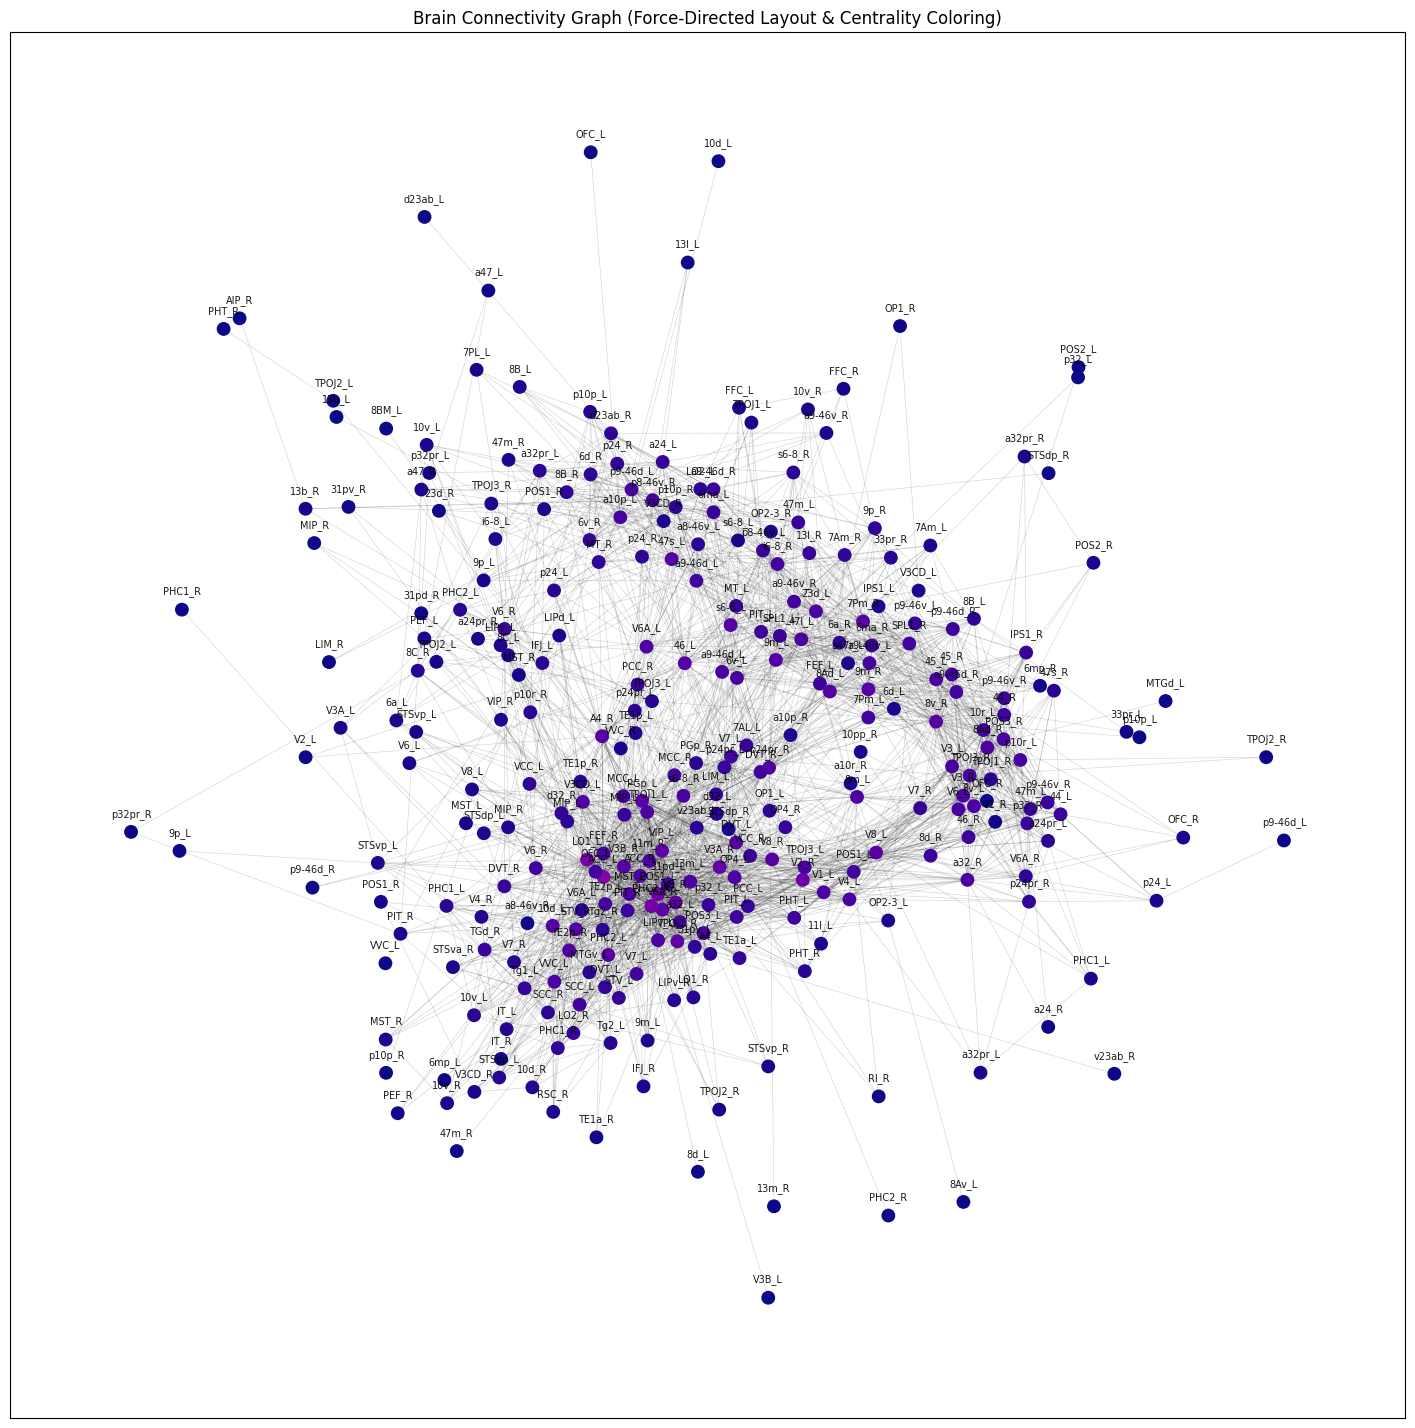


===== Community Detection =====
🔹 Louvain detected 5 communities.

===== Top 10 Most Connected Brain Regions =====
1. Parcel 148 (ACC_L) - Degree Centrality: 0.264
2. Parcel 24 (LO1_L) - Degree Centrality: 0.240
3. Parcel 129 (PHC2_R) - Degree Centrality: 0.226
4. Parcel 132 (POS1_L) - Degree Centrality: 0.213
5. Parcel 3 (V2_R) - Degree Centrality: 0.206
6. Parcel 9 (V3A_R) - Degree Centrality: 0.189
7. Parcel 62 (VIP_L) - Degree Centrality: 0.179
8. Parcel 77 (V8_R) - Degree Centrality: 0.172
9. Parcel 83 (TPOJ1_R) - Degree Centrality: 0.169
10. Parcel 73 (V6A_R) - Degree Centrality: 0.166


In [72]:
#Run pipeline for WM

# Establish raw 3D Matrix on WM data
fmri_wm, labels_wm, fmri_df_wm = matrix_setup("WM", test_mode=False)
# Adjust labels for WM, collapsing them to 0bk=0, 2bk=1 (binary classification)
binary_labels_wm = adjust_wm_labels(labels_wm) #this collapses 0bk vs 2bk to binary labels

#Construct parcellation matrix
fmri_wm, metadata_WM = construct_parcellation_matrix(fmri_wm, fmri_df_wm, 
                                                     standardize=True, 
                                                     test_mode=False)
# Construct target matrix
target_matrix_wm = construct_target_matrix(fmri_wm, binary_labels_wm, 
                                           percentile_threshold=85, 
                                           test_mode=False)
# Construct adjacency matrix for WM
adj_matrix, louvain_partition = construct_adjacency_matrix(
    fmri_wm, threshold=0.3, binarize=True, region_labels=Glasser_parcels_labels, 
    test_mode=True)


In [ ]:
#Run pipeline for Emotion subcondition
fmri_emotion, labels_emotion, fmri_df_emotion = matrix_setup("EMOTION", test_mode=False)
fmri_emotion, metadata_emotion = construct_parcellation_matrix(fmri_emotion, fmri_df_emotion, standardize=True, test_mode=False)
#call target matrix function for Emotion here (only relevant if training on emotion)
# Construct adjacency matrix for EMOTION
adj_matrix_emotion = construct_adjacency_matrix(fmri_emotion, threshold=0.3, binarize=True, test_mode=False)

In [ ]:
#Run pipeline for Language subcondition 
fmri_language, labels_language, fmri_df_language = matrix_setup("LANGUAGE", test_mode=False)
fmri_language, metadata_language = construct_parcellation_matrix(fmri_language, fmri_df_language, standardize=True, test_mode=False)
#call target matrix function for Language here (only relevant if training on language)
# Construct adjacency matrix for LANGUAGE
adj_matrix_language = construct_adjacency_matrix(fmri_language, threshold=0.3, binarize=True, test_mode=False)

**Model Training Pre-processing**

In [74]:
#this tests that we have all the inputs we need for the model
def validate_pipeline_output(fmri_wm, target_matrix_wm, adj_matrix, behavioral_data=None):
    """
    Runs diagnostic checks on the pipeline outputs to ensure compatibility with the GNN-LSTM-MLP model.

    Arguments:
        fmri_wm (np.ndarray): Parcellation matrix (n_exposures, 360, time_steps).
        target_matrix_wm (np.ndarray): Target matrix (n_exposures, 360).
        adj_matrix (np.ndarray): Adjacency matrix (360, 360).
        behavioral_data (np.ndarray, optional): Behavioral data matrix (n_exposures, behavioral_features).

    Returns:
        bool: True if all checks pass, False otherwise.
    """
    print("\n===== Running Pipeline Diagnostics =====")

    # ✅ **Check Shapes**
    expected_fmri_shape = (fmri_wm.shape[0], 360, fmri_wm.shape[2])  # Expecting (batch_size, 360, time_steps)
    expected_target_shape = (fmri_wm.shape[0], 360)  # Expecting (batch_size, 360)
    expected_adj_shape = (360, 360)  # Expecting (360, 360)

    print(f"🔹 fMRI Parcellation Matrix Shape: {fmri_wm.shape}, Expected: {expected_fmri_shape}")
    print(f"🔹 Target Matrix Shape: {target_matrix_wm.shape}, Expected: {expected_target_shape}")
    print(f"🔹 Adjacency Matrix Shape: {adj_matrix.shape}, Expected: {expected_adj_shape}")

    if fmri_wm.shape != expected_fmri_shape:
        print("❌ ERROR: Parcellation matrix shape mismatch!")
        return False
    if target_matrix_wm.shape != expected_target_shape:
        print("❌ ERROR: Target matrix shape mismatch!")
        return False
    if adj_matrix.shape != expected_adj_shape:
        print("❌ ERROR: Adjacency matrix shape mismatch!")
        return False

    # ✅ **Convert to Torch Tensors**
    fmri_wm = torch.tensor(fmri_wm, dtype=torch.float32)
    target_matrix_wm = torch.tensor(target_matrix_wm, dtype=torch.float32)

    # ✅ **Convert adjacency matrix to PyTorch Geometric sparse format**
    adj_matrix_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
    edge_index, edge_attr = dense_to_sparse(adj_matrix_tensor)  # Converts dense adj matrix to sparse format

    print(f"🔹 fMRI Data Type: {fmri_wm.dtype}, Expected: torch.float32")
    print(f"🔹 Target Matrix Data Type: {target_matrix_wm.dtype}, Expected: torch.float32")
    print(f"🔹 Adjacency Matrix Converted to Sparse Format (Edges: {edge_index.shape[1]})")

    # ✅ **Check Normalization**
    if not np.allclose(fmri_wm.mean().item(), 0, atol=1e-1):
        print("⚠️ WARNING: fMRI data may not be properly standardized (mean not ~0).")
    if not np.allclose(fmri_wm.std().item(), 1, atol=1e-1):
        print("⚠️ WARNING: fMRI data may not be properly standardized (std not ~1).")

    # ✅ **Check Behavioral Data**
    if behavioral_data is not None:
        expected_behavioral_shape = (fmri_wm.shape[0], behavioral_data.shape[1])  # Expecting (batch_size, features)
        print(f"🔹 Behavioral Data Shape: {behavioral_data.shape}, Expected: {expected_behavioral_shape}")

        if behavioral_data.shape != expected_behavioral_shape:
            print("❌ ERROR: Behavioral data shape mismatch!")
            return False

        behavioral_data = torch.tensor(behavioral_data, dtype=torch.float32)

        # Normalize behavioral data if necessary
        if not np.allclose(behavioral_data.mean().item(), 0, atol=1):
            print("⚠️ WARNING: Behavioral data may not be properly standardized (mean not ~0).")
        if not np.allclose(behavioral_data.std().item(), 1, atol=1):
            print("⚠️ WARNING: Behavioral data may not be properly standardized (std not ~1).")

    print("✅ All checks passed! Data is ready for the model.")
    return True

#running the check on the main pipeline of data- it should be fine
validate_pipeline_output(fmri_wm, target_matrix_wm, adj_matrix)

#code for checking that we have the behavioural data set up - inactive for now
#validate_pipeline_output(fmri_wm, target_matrix_wm, adj_matrix, behavioural_data)

In [105]:
#Splitting WM data for training
from sklearn.model_selection import train_test_split

# Split indices (subject-wise split is preferred but not available, so we use exposure-wise)
train_idx, val_idx = train_test_split(
    np.arange(fmri_wm.shape[0]), test_size=0.2, random_state=42
)

# Apply split
train_parcel = fmri_wm[train_idx]  # Shape: (train_exposures, 360, time_steps)
val_parcel = fmri_wm[val_idx]      # Shape: (val_exposures, 360, time_steps)

train_target = target_matrix_wm[train_idx]  # Shape: (train_exposures, 360)
val_target = target_matrix_wm[val_idx]      # Shape: (val_exposures, 360)


In [106]:
#Standardisation (after splitting to avoid data leakage)
from sklearn.preprocessing import StandardScaler

# Initialize scalers for each parcel
scalers = [StandardScaler() for _ in range(360)]

# Apply standardization (per parcel, across time)
for i in range(360):
    train_parcel[:, i, :] = scalers[i].fit_transform(train_parcel[:, i, :])
    val_parcel[:, i, :] = scalers[i].transform(val_parcel[:, i, :])


In [107]:
# Convert to PyTorch tensors
train_parcel_tensor = torch.tensor(train_parcel, dtype=torch.float32)
val_parcel_tensor = torch.tensor(val_parcel, dtype=torch.float32)

train_target_tensor = torch.tensor(train_target, dtype=torch.float32)
val_target_tensor = torch.tensor(val_target, dtype=torch.float32)

adj_matrix_tensor = torch.tensor(adj_matrix, dtype=torch.float32)  # Static across all batches


In [120]:
#Setting up prediction inputs
# Run pipeline for EMOTION task
fmri_emotion, labels_emotion, fmri_df_emotion = matrix_setup("EMOTION", test_mode=False)
fmri_emotion, metadata_emotion = construct_parcellation_matrix(fmri_emotion, fmri_df_emotion, standardize=True, test_mode=False)
# Construct adjacency matrix for EMOTION
adj_matrix_emotion = construct_adjacency_matrix(fmri_emotion, threshold=0.3, binarize=True, test_mode=False)

# Run pipeline for LANGUAGE task (already exists)
fmri_language, labels_language, fmri_df_language = matrix_setup("LANGUAGE", test_mode=False)
fmri_language, metadata_language = construct_parcellation_matrix(fmri_language, fmri_df_language, standardize=True, test_mode=False)
adj_matrix_language = construct_adjacency_matrix(fmri_language, threshold=0.3, binarize=True, test_mode=False)






===== Running fMRI Data Processing for EMOTION =====
🔍 Checking: RUNS[0] = LR for experiment EMOTION
🔍 Checking: RUNS[1] = RL for experiment EMOTION
✅ fMRI DataFrame loaded with shape: (280, 368)
✅ Dropped irrelevant columns: run, experiment, EV_amplitude
✅ Encoded condition labels numerically
✅ Aligned time-series exposures and dropped onset/duration columns
📊 Data dimensions: n_exposures=255, n_parcels=360, time_steps=61
✅ 3D fMRI matrix constructed with shape: (255, 360, 61)

===== Constructing Parcellation Matrix =====
✅ Data dimensions: n_exposures=255, n_parcels=360, time_steps=61
✅ Applied Z-score normalization to parcels across time.
✅ Parcellation matrix constructed successfully!

===== Constructing Adjacency Matrix =====
✅ Adjacency matrix constructed with shape: (360, 360)

===== Running fMRI Data Processing for LANGUAGE =====
🔍 Checking: RUNS[0] = LR for experiment LANGUAGE
🔍 Checking: RUNS[1] = RL for experiment LANGUAGE
✅ fMRI DataFrame loaded with shape: (590, 368)
✅ Dr

In [124]:
#Set up batching
from torch.utils.data import TensorDataset, DataLoader

# Set batch size
batch_size = 32

# Ensure correct shape (add feature dimension)
emotion_parcel_tensor = emotion_parcel_tensor.unsqueeze(-1)  # Ensure 4D input
language_parcel_tensor = language_parcel_tensor.unsqueeze(-1)  # Ensure 4D input

# Create PyTorch Datasets
train_dataset = TensorDataset(train_parcel_tensor, train_target_tensor)  # ✅ No adjacency matrix
val_dataset = TensorDataset(val_parcel_tensor, val_target_tensor)  # ✅ No adjacency matrix

# Convert Emotion & Language parcellation matrices to PyTorch tensors
emotion_parcel_tensor = torch.tensor(fmri_emotion, dtype=torch.float32)  # Ensure it's correctly sourced
language_parcel_tensor = torch.tensor(fmri_language, dtype=torch.float32)  # Ensure it's correctly sourced

# Ensure the feature dimension exists in the parcel tensors
train_parcel_tensor = train_parcel_tensor.unsqueeze(-1)  # (Batch, 360, Time Steps, 1)
val_parcel_tensor = val_parcel_tensor.unsqueeze(-1)  # Same for validation
test_parcel_tensor_emotion = test_parcel_tensor_emotion.unsqueeze(-1)
test_parcel_tensor_language = test_parcel_tensor_language.unsqueeze(-1)

# Create PyTorch Datasets
train_dataset = TensorDataset(train_parcel_tensor, train_target_tensor)  # No adjacency here
val_dataset = TensorDataset(val_parcel_tensor, val_target_tensor)

# Emotion & Language datasets (only parcel data, no targets)
test_dataset_emotion = TensorDataset(test_parcel_tensor_emotion)  # No labels
test_dataset_language = TensorDataset(test_parcel_tensor_language)  # No labels

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_emotion = DataLoader(test_dataset_emotion, batch_size=batch_size, shuffle=False)
test_loader_language = DataLoader(test_dataset_language, batch_size=batch_size, shuffle=False)


NameError: name 'test_parcel_tensor_emotion' is not defined

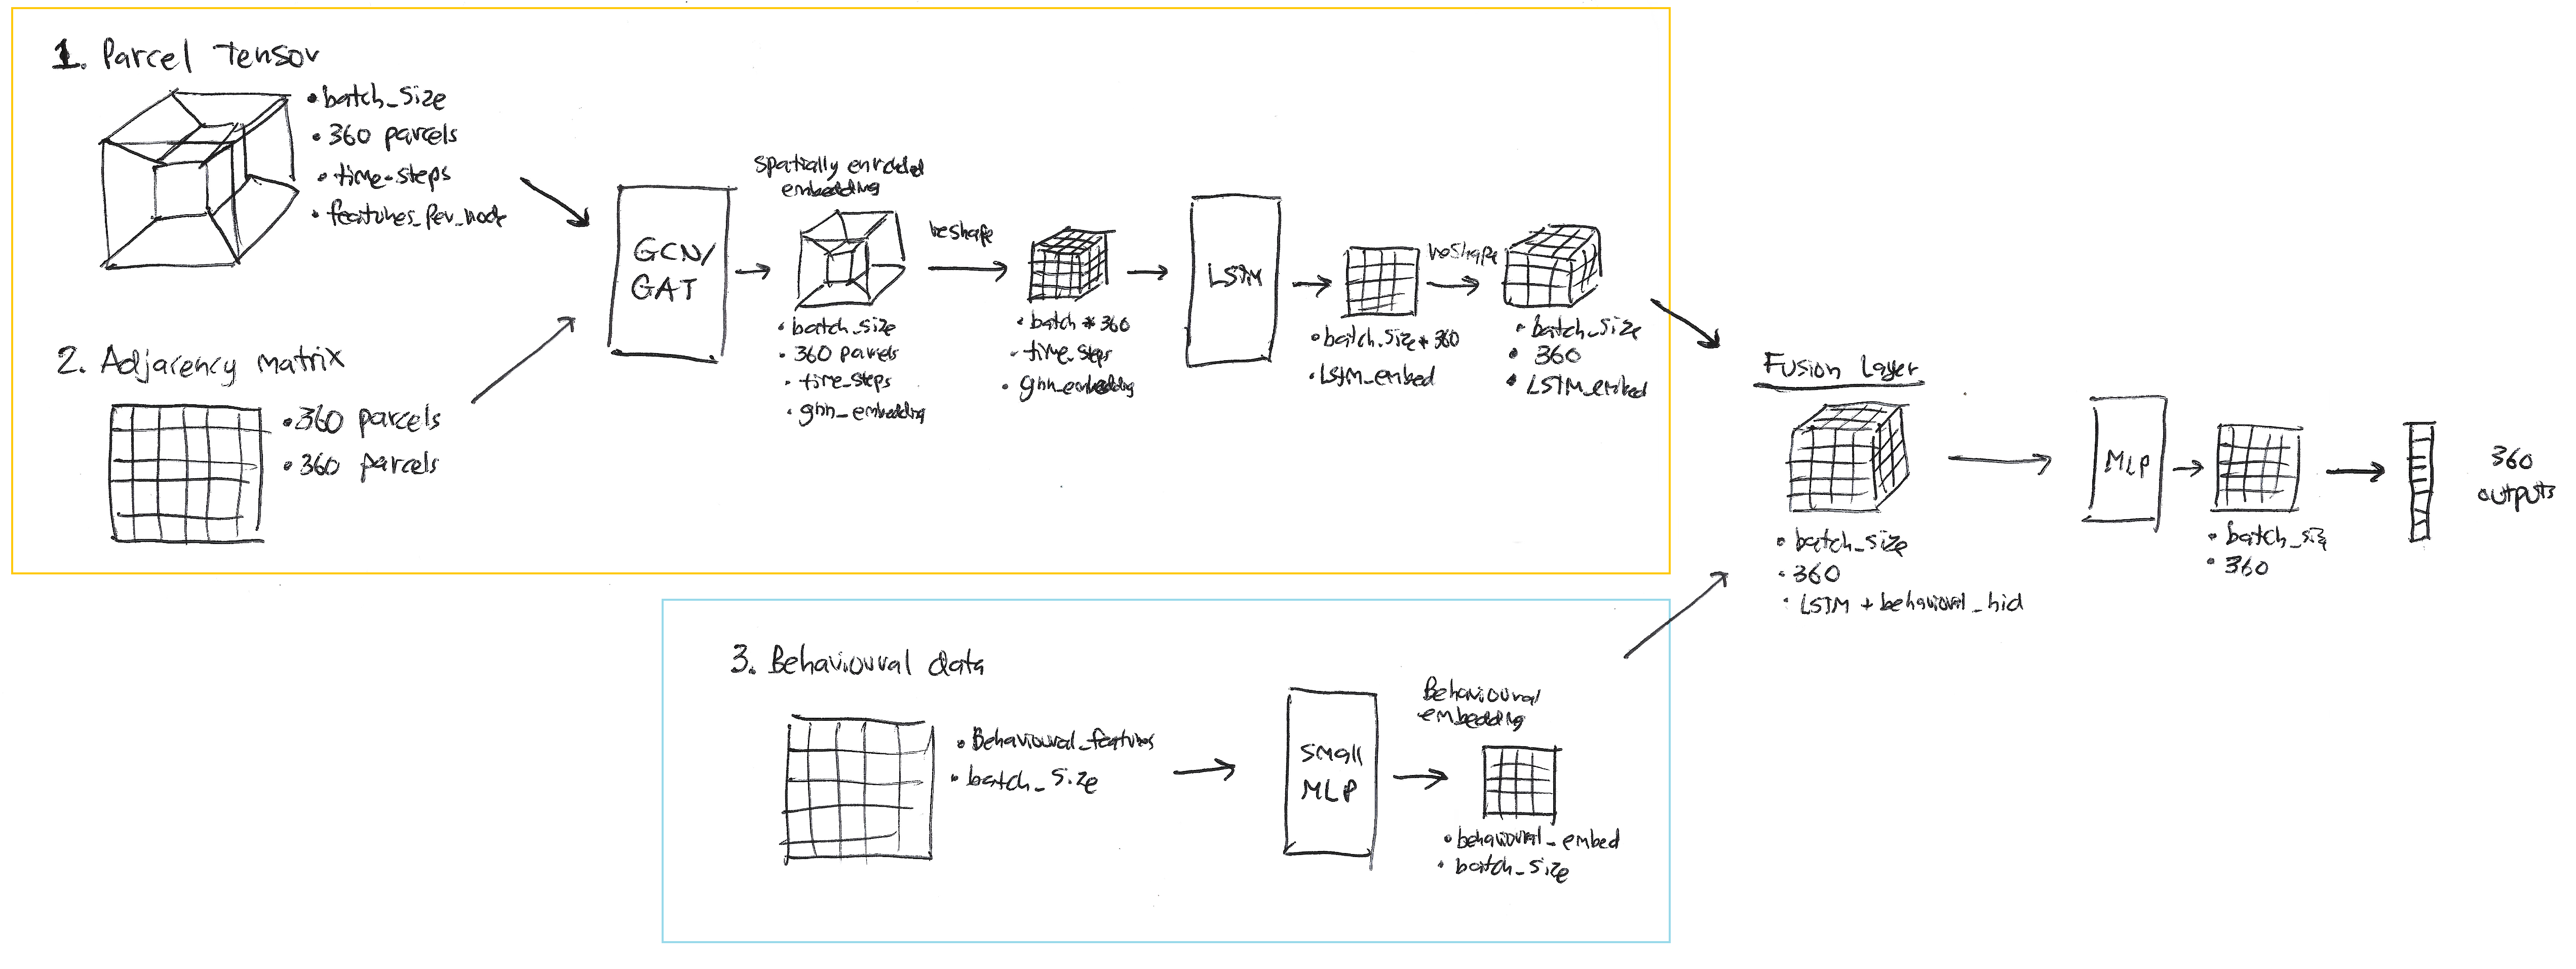

In [121]:
#Hybrid model
class GNN_LSTM_MLP(nn.Module):
    def __init__(self, 
                 num_parcels, time_steps, features_per_node,
                 gnn_type="GCN", gnn_layers=1, gnn_hidden_dim=64, 
                 lstm_layers=1, lstm_hidden_dim=128, 
                 mlp_layers=1, mlp_hidden_dim=64, 
                 dropout_rate=0.5, batch_norm=True):
        super(GNN_LSTM_MLP, self).__init__()

        self.num_parcels = num_parcels
        self.time_steps = time_steps
        self.features_per_node = features_per_node
        self.dropout_rate = dropout_rate
        self.batch_norm = batch_norm

        # === GNN Layer Selection ===
        gnn_choices = {"GCN": GCNConv, "GAT": GATConv, "GraphConv": GraphConv}
        gnn_layer = gnn_choices[gnn_type]

        self.gnn_layers = nn.ModuleList([
            gnn_layer(features_per_node if i == 0 else gnn_hidden_dim, gnn_hidden_dim)
            for i in range(gnn_layers)
        ])

        # === LSTM Layer ===
        self.lstm = nn.LSTM(input_size=gnn_hidden_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True)

        # === MLP Layer ===
        mlp_modules = []
        for _ in range(mlp_layers - 1):
            mlp_modules.extend([
                nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.BatchNorm1d(mlp_hidden_dim) if batch_norm else nn.Identity()
            ])
        mlp_modules.append(nn.Linear(mlp_hidden_dim, 1))
        mlp_modules.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*mlp_modules)

    def forward(self, parcel_data, adj_matrix):
        """
        Forward pass: GNN -> LSTM -> MLP
        """
        batch_size, num_parcels, time_steps, _ = parcel_data.shape
        x = parcel_data.view(batch_size * time_steps, num_parcels, -1)  # Reshape for GNN

        # === GNN Processing ===
        for gnn in self.gnn_layers:
            x = gnn(x, adj_matrix)
            x = F.relu(x)

        x = x.view(batch_size, time_steps, num_parcels, -1)  # Reshape for LSTM
        x = x.permute(0, 2, 1, 3).reshape(batch_size * num_parcels, time_steps, -1)  # (B*360, T, F)

        # === LSTM Processing ===
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :].view(batch_size, num_parcels, -1)  # Take last time-step

        # === MLP Classification ===
        out = self.mlp(lstm_out).squeeze(-1)  # (batch_size, num_parcels)

        return out

    def train_model(self, train_loader, val_loader, adj_matrix_tensor, learning_rate=0.001, epochs=20):
        """
        Trains the model using BCE Loss and Adam optimizer.
        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_fn = nn.BCELoss()

        for epoch in range(epochs):
            self.train()
            total_loss = 0

            for parcel_data, labels in train_loader:  # Removed adjacency matrix from loader
                optimizer.zero_grad()
                output = self(parcel_data, adj_matrix_tensor)  # Pass adjacency separately
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            val_acc = self.evaluate(val_loader, adj_matrix_tensor)  # Pass adjacency separately
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Validation Accuracy: {val_acc:.4f}")


    def evaluate(self, val_loader, adj_matrix_tensor):
        """
        Evaluates model accuracy on validation set.
        """
        self.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for parcel_data, labels in val_loader:
                output = self(parcel_data, adj_matrix_tensor)  # Pass adjacency separately
                predictions = (output > 0.5).float()
                correct += (predictions == labels).sum().item()
                total += labels.numel()
        return correct / total


    def predict_task(self, test_loader):
        """
        Predicts on a new HCP task (e.g., Emotion or Language).
        """
        self.eval()
        predictions = []

        with torch.no_grad():
            for parcel_data, adj_matrix, _ in test_loader:
                output = self(parcel_data, adj_matrix)
                predictions.append((output > 0.5).float())

        return torch.cat(predictions, dim=0)

    def visualize_predictions(self, test_loader, task_name, labels_dict):
        """
        Generates a frequency distribution plot of predicted activations across parcels.
        """
        predictions = self.predict_task(test_loader).cpu().numpy()
        parcel_counts = np.sum(predictions, axis=0)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(labels_dict.values()), y=parcel_counts)
        plt.xticks(rotation=90)
        plt.ylabel("Activation Frequency")
        plt.title(f"Predicted Activations for {task_name} Task")
        plt.show()



In [122]:
# Initialize Model
model = GNN_LSTM_MLP(
    num_parcels=360, time_steps=50, features_per_node=1,
    gnn_type="GAT", gnn_layers=2, gnn_hidden_dim=64,
    lstm_layers=2, lstm_hidden_dim=128,
    mlp_layers=2, mlp_hidden_dim=64,
    dropout_rate=0.3, batch_norm=True
)

# Train Model (with adjacency passed separately)
model.train_model(train_loader, val_loader, adj_matrix_tensor, learning_rate=0.001, epochs=20)

# Predict on Emotion Task
model.visualize_predictions(test_loader_emotion, "Emotion", Glasser_parcels_labels)

# Predict on Language Task
model.visualize_predictions(test_loader_language, "Language", Glasser_parcels_labels)


ValueError: not enough values to unpack (expected 4, got 3)

In [102]:
from torch.nn.utils.rnn import pad_sequence

# Example: Pad emotion data to match the WM dataset's 135 time steps
padded_emotion_data = pad_sequence(emotion_parcel_tensor, batch_first=True, padding_value=0)
